In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import itertools

import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по 1 месяцу.

In [3]:
df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

<AxesSubplot:xlabel='Date'>

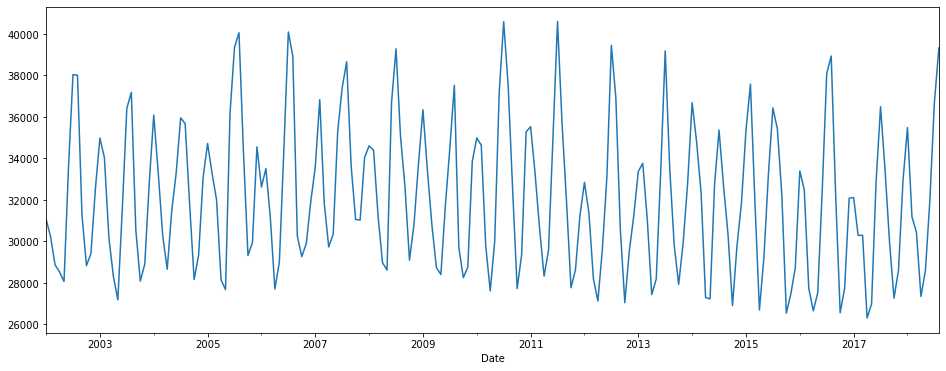

In [4]:
data = df.resample('1M').mean()
data['PJME_MW'].plot(figsize=(16,6))

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200 entries, 2002-01-31 to 2018-08-31
Freq: M
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PJME_MW          200 non-null    float64
 1   year             200 non-null    float64
 2   month            200 non-null    float64
 3   dayofmonth       200 non-null    float64
 4   quarter          200 non-null    float64
 5   dayofyear        200 non-null    float64
 6   weekofyear       200 non-null    float64
 7   dayofweek        200 non-null    float64
 8   hour             200 non-null    float64
 9   is_holiday       200 non-null    float64
 10  is_prev_holiday  200 non-null    float64
 11  is_next_holiday  200 non-null    float64
dtypes: float64(12)
memory usage: 20.3 KB


### 2. Подберите параметры модели SARIMAX для этого ряда.

Для этого используем ACF (определит q) и PACF (определит p)

ACF - автокорреляционная функция, по коррелограмме которой можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA. 

PACF - автокорреляционная функция первых разностей, по коррелограмме которой можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR. 

В области анализа временных рядов модель авторегрессии (autoregressive, AR) и модель скользящего среднего (moving average, MA) является сравнительно простой и оперирует 2-мя параметрами: глубиной регрессии - р и длиной скользящего среднего - q. Чем больше q - тем больше сглаживание ряда 
ARIMA - Интегрированная Авторегрессионная модель скользящего среднего, построена для ряда первых разностей. Определяется на 3-х параметрах : p — порядок компоненты AR, d — порядок интегрированного ряда, q — порядок компонеты MA.

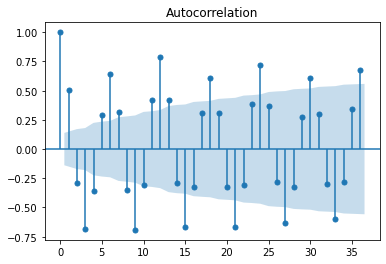

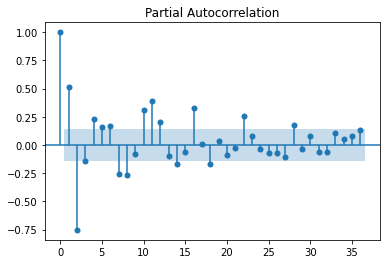

In [6]:
sm.graphics.tsa.plot_acf(data['PJME_MW'].values, lags=12*3)
plt.show()

sm.graphics.tsa.plot_pacf(data['PJME_MW'].values, lags=12*3)
plt.show()

In [8]:
# Примем отталкиваясь от ACF  значения q = [1, 6]
# PACF p [1, 2]

In [9]:
q = [1, 6]
d = [0, 1]
p = [1, 2]
pdq = list(itertools.product(p, d, q))  
pdq

[(1, 0, 1),
 (1, 0, 6),
 (1, 1, 1),
 (1, 1, 6),
 (2, 0, 1),
 (2, 0, 6),
 (2, 1, 1),
 (2, 1, 6)]

In [10]:
p = [0, 1]
d = [1, 2]
q = [1, 2]
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 2, 1, 12),
 (0, 2, 2, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 2, 1, 12),
 (1, 2, 2, 12)]

In [12]:
min_aic = np.inf

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data['PJME_MW'].values[:-12],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            
            
            if results.aic < min_aic:
                print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
                min_aic = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
            
        except:
            continue

ARIMA(1, 0, 1)x(0, 1, 1, 12) - AIC:2880.30709277507
ARIMA(1, 0, 1)x(0, 1, 2, 12) - AIC:2657.681956677833
ARIMA(1, 0, 1)x(0, 2, 2, 12) - AIC:2542.3912136424256
ARIMA(1, 0, 6)x(0, 2, 2, 12) - AIC:2442.9864259146025
ARIMA(2, 1, 6)x(0, 2, 2, 12) - AIC:2442.45207966974


In [13]:
print('Лучшие параметры для ARIMA{}x{} - AIC:{}'.format(best_params, best_seasonal_params, min_aic))

Лучшие параметры для ARIMA(2, 1, 6)x(0, 2, 2, 12) - AIC:2442.45207966974


In [14]:
model = sm.tsa.statespace.SARIMAX(data['PJME_MW'].values[:-12],order=best_params,
                                    seasonal_order=best_seasonal_params ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

In [15]:
model_result = model.fit()

In [16]:
print('ARIMA{} - AIC:{}'.format(best_params, model_result.aic))

ARIMA(2, 1, 6) - AIC:2442.45207966974


In [17]:
print(model_result.summary().tables[0],model_result.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  188
Model:             SARIMAX(2, 1, 6)x(0, 2, 2, 12)   Log Likelihood               -1210.226
Date:                            Wed, 05 Aug 2020   AIC                           2442.452
Time:                                    09:06:44   BIC                           2474.163
Sample:                                         0   HQIC                          2455.338
                                            - 188                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

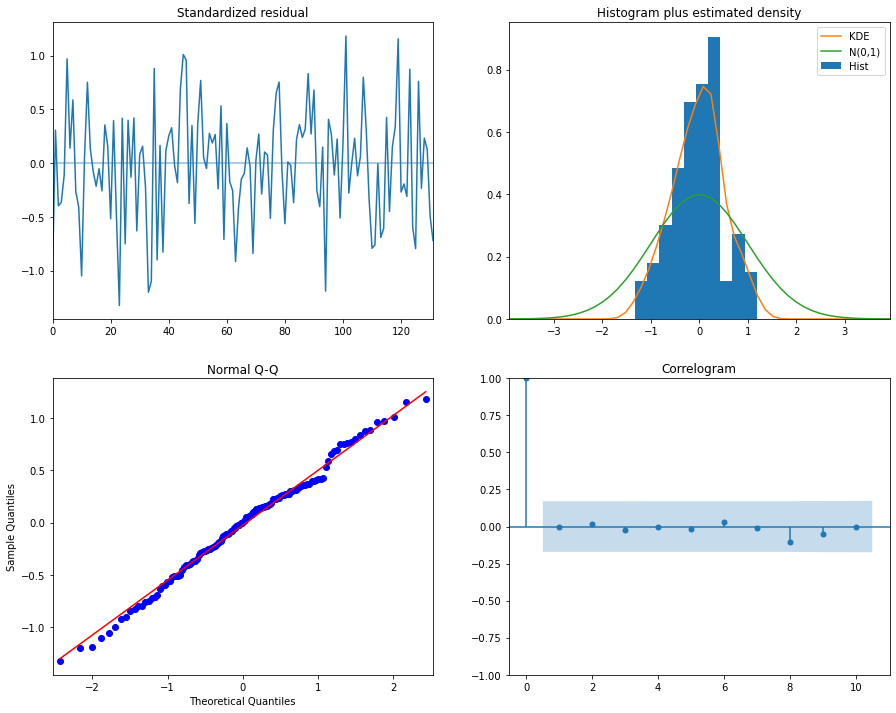

In [18]:
model_result.plot_diagnostics(figsize=(15, 12))
plt.show()

In [21]:
model_forecast = model_result.forecast(24)

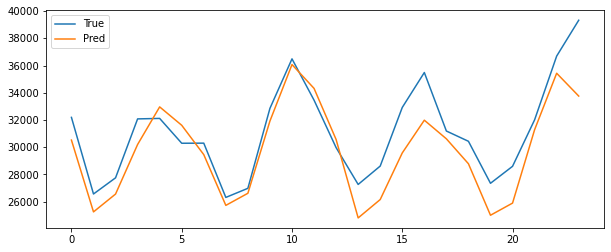

In [22]:
plt.figure(figsize=(10, 4))
plt.plot(data['PJME_MW'][-24:].values, label='True')
plt.plot(model_forecast, label='Pred')
plt.legend()


In [ ]:
sm.tsa.stattools.adfuller(model_result.resid)

### 3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

Можем считать остатки стационарным рядом <br>
Наблюдаем нормальное распределение <br>

### 4. Возмите вариант 1 или 2

            Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)
            Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19 (по любой стране кроме Китая на дневных графиках )


In [24]:
df = pd.read_csv('my_BRENT2019.csv', index_col=[0], parse_dates=[0])
df.head(2)

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0


<AxesSubplot:xlabel='Дата'>

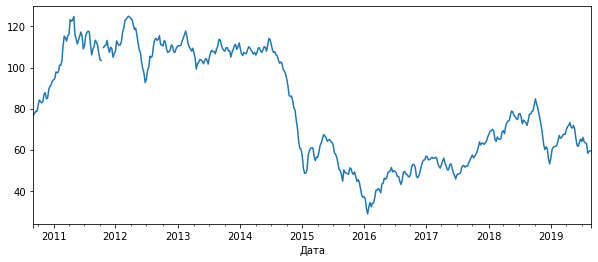

In [30]:
target = 'Значение'
data = df.resample('W').mean()
data[target].plot(figsize=(10, 4))

In [31]:
data.fillna(method='pad', inplace=True)

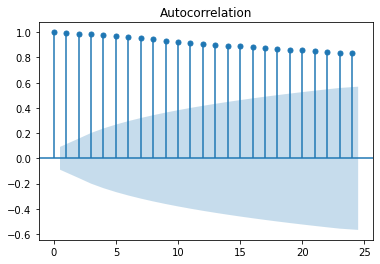

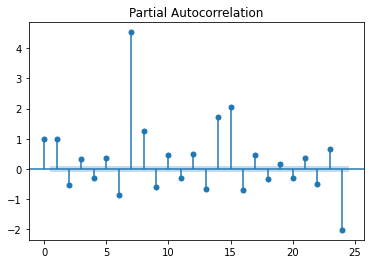

In [32]:
sm.graphics.tsa.plot_acf(data[target].values, lags=4*6)
plt.show()

sm.graphics.tsa.plot_pacf(data[target].values, lags=4*6)
plt.show()

In [36]:
p = d = q = range(3)
pdq = list(itertools.product(p, d, q))   
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [37]:
seasonal_pdq = [0, 0, 0, 0]

In [38]:
min_aic = np.inf

for param in pdq:
    param_seasonal = seasonal_pdq
    try:
        mod = sm.tsa.statespace.SARIMAX(data[target].values[:-26],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

        results = mod.fit()
            
            
        if results.aic < min_aic:
            print('ARIMA{} - AIC:{}'.format(param, results.aic))
            min_aic = results.aic
            best_params = param
            best_seasonal_params = param_seasonal
            
    except:
        continue

ARIMA(0, 0, 0) - AIC:5206.183485066702
ARIMA(0, 0, 1) - AIC:4599.416034387374
ARIMA(0, 0, 2) - AIC:4051.1384812972537
ARIMA(0, 1, 0) - AIC:1983.2190824115814
ARIMA(0, 1, 1) - AIC:1925.5797485411867
ARIMA(0, 1, 2) - AIC:1923.9352814357778
ARIMA(1, 1, 2) - AIC:1923.7062676586345


In [39]:
model_brent = sm.tsa.statespace.SARIMAX(data[target].values[:-26],order=best_params,
                                    seasonal_order=best_seasonal_params ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

In [40]:
brent_result = model_brent.fit()
brent_result.aic

1923.7062676586345

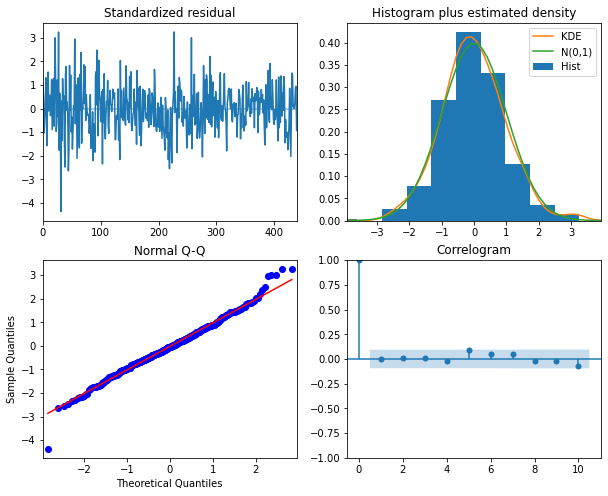

In [41]:
brent_result.plot_diagnostics(figsize=(10, 8))
plt.show()

### 5. Оцените результат моделирования

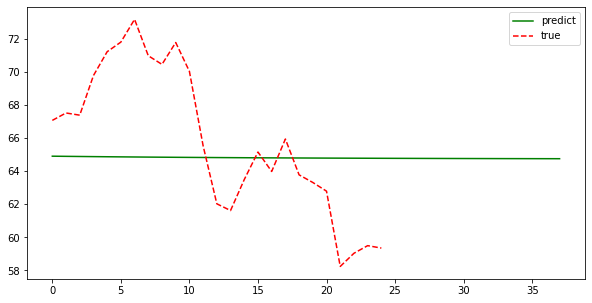

In [44]:
plt.figure(figsize=(10,5))
brent_fc = brent_result.forecast(38)
plt.plot(brent_fc,'g', label='predict' )
plt.plot(data[target].values[-25:],'--r',label='true')
plt.legend()

Данная модель не сработа на данных с нефтью, вместо прогноза мы получием усредненное значение за период.

### 6. Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе AR I MA.

In [43]:
Предполагаю, что модели ARIMA хорошо работают с данными, обладающими сезонностью и с незначительными выбросами. 

SyntaxError: invalid syntax (<ipython-input-43-e2d2ff193488>, line 1)